# plotting temp and sal 

dev_FVCOM_2D_dsのfvcomクラスによるfvcom_outputの読み込みを元に、データのplottingと相関係数、RMSEの計算を行う。pyfvcomのFileReaderを用いるとplotは簡単になるものの、読み込みに膨大な時間がかかるため用いない。

In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
from functools import partial, partialmethod
import pyproj
from pyproj import Proj
### import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import holoviews as hv
from holoviews import opts
import datashader.utils as du
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize,\
    spread, aggregate, regrid
from holoviews.operation import decimate
import holoviews.plotting.mpl
import geoviews as gv
from bokeh import models
import subprocess
from bokeh.io import export_png
#hv.extension('bokeh', 'matplotlib')

In [80]:
#出来上がった関数をここに置いていく
class Fvcom2D:
    '''
    Postprocessing for FVCOM 4 netcdf output in its original coordinates
    '''
    def __init__(self, ncfile_path='tst_0001.nc', 
                 obcfile_path='tst_obc.dat', m_to_km=True, offset=False):
        '''
        Parameters
        ----------
        ncfile_path : str
            FVCOM output netcdf file
        obcfile_path : str
            FVCOM casename_obc.dat file
        m_to_km : bool
            = True if converting x and y axis units from m to km.
        offset : bool
           offset = True if the left-bottom corner is set to the origin.

        Returns
        -------
        Instance of class FVCOM2D
        '''

        self.fvcom_nc=ncfile_path
        if os.path.isfile(self.fvcom_nc):
            self.FVCOM = netCDF4.Dataset(self.fvcom_nc, 'r')
        else:
            print(f"ERROR: File {self.fvcom_nc} does not exit.")
            sys.exit()
        self.variables = self.FVCOM.variables
        print(f"Dictionaly keys of netCDF4.Dataset = {self.variables.keys()}")
        self.fobc=obcfile_path # = None if not exist
        if os.path.isfile(self.fobc):
            df = pd.read_csv(self.fobc, header=None, skiprows=1, delim_whitespace=True)
            ### -1 because index in FVCOM starts from 1 while from 0 in Python
            self.node_bc = df.iloc[:,1].values - 1
            print(f"Open boundary nodes = {self.node_bc}")
        else:
            print(f"ERROR: File {self.fobc} does not exit.")
            sys.exit()            
        self.x, self.y = self.variables['x'][:], self.variables['y'][:] ### at node
        self.xc, self.yc = self.variables['xc'][:], self.variables['yc'][:]   ### at cell center
        # Convert axis units from m to km
        if m_to_km:
            self.x /= 1000.0; self.y /= 1000.0; self.xc /= 1000.0; self.yc /= 1000.0
        # Set the left-bottom corner as the coordinate origin. 
        if offset:
            xmin = self.x.min(); ymin = self.y.min()
            self.x -= xmin; self.y -= ymin; self.xc -= xmin; self.yc -= ymin
        # Gets sigma coordinate values
        self.siglay, self.siglev = self.variables['siglay'][:], self.variables['siglev'][:]
        # Get time variables
        self.iint = self.variables['iint'][:]
        self.time = self.variables['time'][:]
        self.Itime = self.variables['Itime'][:]
        self.Itime2 = self.variables['Itime2'][:]
        # Gets bathymetry
        self.z = self.variables['h'][:]
        # Gets verts = [(x0,y0,h0),[x1,y1,h1],...,[xn,yn,hn]]
        verts = [(xi, yi, hi) for xi, yi, hi in zip(self.x.data, self.y.data, self.z.data)]
        self.verts = pd.DataFrame(verts, columns=['x', 'y', 'z'])
        # Gets connectivity array nv (3 node numbers of element i)
        nv = self.variables['nv'][:].T - 1
        self.triang = tri.Triangulation(self.x, self.y, triangles=nv)
        # Since node indexes in an element are defined clockwise in FVCOM,
        #     change them to counterclockwise, which is the matplotlib.tri specification.
        # FVCOMでは時計回りに定義されているので，matplotlib.triの仕様である反時計回りに変更する．
        # node番号自体は不変．
        self.nv=nv[:,::-1]
        self.tris = pd.DataFrame(self.nv, columns=['v0', 'v1', 'v2'])
        self.mesh = du.mesh(self.verts, self.tris) 
        self.trimesh = hv.TriMesh((self.tris, self.verts))
        # Element index of 3 neighbors of element i
        # 各セルには一般に3つのセルが隣接（境界セルはこの限りではない）
        self.nbe = np.array([[self.nv[n, j], self.nv[n, (j+2)%3]] \
            for n in range(len(self.triang.neighbors)) \
            for j in range(3) if self.triang.neighbors[n,j] == -1])
    def time_list(self):
        Time_list = []
        Times = self.variables['Times']
        for i in range(len(Times)):
            time =Times[i].data
            bytes_time = b''
            for j in range(19):
                bytes_time = bytes_time + time[j]
            time2 = bytes_time.decode('utf-8')
            time2 = time2.replace('T',' ')
            Time_list.append(time2)
        return Time_list

    @property
    def timestamp(self):
        '''
        Create time stamp list in ["D HH:MM:SS"]
        '''
        dayi = self.Itime
        hourf = self.Itime2 / 3600000
        houri = hourf.astype('int32')
        minf = (hourf - houri) * 60
        mini = minf.astype('int32')
        secf = (minf - mini) * 60
        seci = secf.astype('int32')
        return [f"{d} {h:02}:{m:02}:{s:02}" for d, h, m, s in zip(dayi, houri, mini, seci)]
    
def find_closest_node(stn):
    """
    moniteringpostから最近傍の場所を抽出
    """
    index = {}
    p = Proj(proj='utm',zone=54,ellps='WGS84', preserve_units=False)
    
    for key in stn.keys():
        st_m = p(stn[key][0],stn[key][1]) #lon,lat→utm(m)
        st_km= st_m[0]/1000,st_m[1]/1000 #utm(m)→utm(km)
        dist = [math.sqrt((fvcom.x[i]-st_km[0])**2 +(fvcom.y[i]-st_km[1])**2) for i in range(len(fvcom.x))] #全nodeからの距離を計算、listで保存
        #listの中から最小値を見つける
        res ,min_dist= dist.index(min(dist)),min(dist) #indexを取得
        index[key] = res
        print(f"Node {res} is {min_dist}km to the station:{key}")
        
    return index

def calc_cc(x,y):
    s1 = pd.Series(x)
    s2 = pd.Series(y)
   # print(s1,s2)
    res = s2.corr(s1)
    return res
    
    

def regression(df,var):
    """
    回帰直線を一時間おきに計算
    df:moniteringpostのSをpandasDataFrameにしたもの
        levは各地点で異なる freq=1h　nlevは同一地点なら変化しない前提
    var:回帰させたい変数
    return:日付をkeyとした回帰直線の係数(y=ax+b)の(a,b)
    """
    dates = df['datetime'].unique()
    df = df.dropna(subset=['tp','sl']) #空を落とす
    regress = {}
    
    for key in dates:
        mask = (df['datetime'] == key)
        tmp = df[mask]

        x  = np.array(tmp['depth'])
        
        if x.size <= 2: #表層のみのデータや、データ数が極端に少ないものは回帰直線の値がおかしくなるので外す
            regress[key] = np.array([0,0]) #欠損処理 →これにより後で欠損値=0になり、その値をnanにできるが、0℃になることを考えると好ましくないかも。
        else:
            if var == 'salinity':
                y = np.array(tmp['sl'])
                regress[key] = np.polyfit(x,y,1) #polyfit:1なら線形回帰 np.arrayが必要
            else:
                y = np.array(tmp['tp'])
                regress[key] = np.polyfit(x,y,1)

    return regress




In [81]:
#variables
f = '../examples/Tokyo2_15_0001.nc'
obcfile = 'C:/Users/ishid/fvcominputs/input/TokyoBay_obc.dat'
fvcom = Fvcom2D(ncfile_path=f, obcfile_path=obcfile, m_to_km=True, offset=False)
temp = fvcom.variables['temp']
sal = fvcom.variables['salinity']
stn ={'chiba1buoy':(139.9542517,35.53703833),'chibaharo':(140.0233033,35.61095833),'kawasaki':(139.8340267,35.49019),'urayasu':(139.9417417,35.640085)}

Dictionaly keys of netCDF4.Dataset = dict_keys(['nprocs', 'partition', 'x', 'y', 'lon', 'lat', 'xc', 'yc', 'lonc', 'latc', 'siglay', 'siglev', 'h', 'nv', 'iint', 'time', 'Itime', 'Itime2', 'Times', 'zeta', 'u', 'v', 'tauc', 'omega', 'ww', 'ua', 'va', 'temp', 'salinity', 'viscofm', 'viscofh', 'km', 'kh', 'kq', 'q2', 'q2l', 'l', 'uwind_speed', 'vwind_speed', 'wet_nodes', 'wet_cells', 'wet_nodes_prev_int', 'wet_cells_prev_int', 'wet_cells_prev_ext', 'inundation_cells'])
Open boundary nodes = [461 480 503 507 510 511 509 508 512 531 560 589 615 618 619 637 660 669
 688 704 703 702 706 721 728 729 735 749 748 750 751 768 769 782 783 793
 794 805 806 808 809 821 822 833 847 848 864 877 878 879 892 905 918 928
 936 942 947 952 955 957]


In [6]:
#calc each regression 5分くらいかかる
regress_dict_tp = {}
for key in stn:
    f = 'C:/Users/ishid/Github/Puppeteer/src/csv/Mpos_S_' + key +'_2019.csv'
    df = pd.read_csv(f)
    regress = regression(df,'temprature')
    regress_dict_tp[key] = regress
    print(regress_dict_tp[key])


{'2019-01-01 00:00:00': array([-6.74915829e-03,  1.19395088e+01]), '2019-01-01 01:00:00': array([-7.31230380e-03,  1.19129703e+01]), '2019-01-01 02:00:00': array([-7.31230380e-03,  1.19029703e+01]), '2019-01-01 03:00:00': array([-7.31230380e-03,  1.18926778e+01]), '2019-01-01 04:00:00': array([-6.73198267e-03,  1.18756450e+01]), '2019-01-01 05:00:00': array([-7.88690521e-03,  1.18912197e+01]), '2019-01-01 06:00:00': array([-7.32355484e-03,  1.18877628e+01]), '2019-01-01 07:00:00': array([-6.7577461e-03,  1.1894583e+01]), '2019-01-01 08:00:00': array([-7.32355484e-03,  1.18679093e+01]), '2019-01-01 09:00:00': array([-8.45906801e-03,  1.18614364e+01]), '2019-01-01 10:00:00': array([-9.01891594e-03,  1.18358483e+01]), '2019-01-01 11:00:00': array([-1.18518191e-02,  1.18561379e+01]), '2019-01-01 12:00:00': array([-9.59064925e-03,  1.17975985e+01]), '2019-01-01 13:00:00': array([-0.01587972, 11.89700871]), '2019-01-01 14:00:00': array([-0.01816665, 11.93588591]), '2019-01-01 15:00:00': arra

{'2019-01-01 00:00:00': array([ 0.23460119, 10.06571989]), '2019-01-01 01:00:00': array([ 0.17625569, 10.17792603]), '2019-01-01 02:00:00': array([ 0.08893516, 10.3811785 ]), '2019-01-01 03:00:00': array([ 0.05069294, 10.4989573 ]), '2019-01-01 04:00:00': array([ 0.04209366, 10.48284104]), '2019-01-01 05:00:00': array([ 0.03802368, 10.32520061]), '2019-01-01 06:00:00': array([ 0.06329021, 10.21345043]), '2019-01-01 07:00:00': array([ 0.02998349, 10.46390389]), '2019-01-01 08:00:00': array([ 0.05468138, 10.38611536]), '2019-01-01 09:00:00': array([ 0.10313563, 10.28591609]), '2019-01-01 10:00:00': array([ 0.1620692 , 10.21295287]), '2019-01-01 11:00:00': array([ 0.14555756, 10.33932837]), '2019-01-01 12:00:00': array([ 0.12930094, 10.42551589]), '2019-01-01 13:00:00': array([ 0.13301003, 10.47619258]), '2019-01-01 14:00:00': array([ 0.13206766, 10.49211413]), '2019-01-01 15:00:00': array([ 0.15104042, 10.55029553]), '2019-01-01 16:00:00': array([ 0.13285978, 10.57056472]), '2019-01-01 1

{'2019-01-01 00:00:00': array([0, 0]), '2019-01-01 01:00:00': array([0, 0]), '2019-01-01 02:00:00': array([0, 0]), '2019-01-01 03:00:00': array([0, 0]), '2019-01-01 04:00:00': array([0, 0]), '2019-01-01 05:00:00': array([0, 0]), '2019-01-01 06:00:00': array([0, 0]), '2019-01-01 07:00:00': array([0, 0]), '2019-01-01 08:00:00': array([0, 0]), '2019-01-01 09:00:00': array([0, 0]), '2019-01-01 10:00:00': array([0, 0]), '2019-01-01 11:00:00': array([0, 0]), '2019-01-01 12:00:00': array([0, 0]), '2019-01-01 13:00:00': array([0, 0]), '2019-01-01 14:00:00': array([0, 0]), '2019-01-01 15:00:00': array([0, 0]), '2019-01-01 16:00:00': array([0, 0]), '2019-01-01 17:00:00': array([0, 0]), '2019-01-01 18:00:00': array([0, 0]), '2019-01-01 19:00:00': array([0, 0]), '2019-01-01 20:00:00': array([0, 0]), '2019-01-01 21:00:00': array([0, 0]), '2019-01-01 22:00:00': array([0, 0]), '2019-01-01 23:00:00': array([0, 0]), '2019-01-02 00:00:00': array([0, 0]), '2019-01-02 01:00:00': array([0, 0]), '2019-01-02

{'2019-01-01 00:00:00': array([-0.13813652, 11.21818745]), '2019-01-01 01:00:00': array([-0.15356433, 11.49082681]), '2019-01-01 02:00:00': array([-0.10619939, 11.28593058]), '2019-01-01 03:00:00': array([-0.12572549, 11.42911844]), '2019-01-01 04:00:00': array([-0.07307749, 10.63197089]), '2019-01-01 05:00:00': array([0.47993852, 7.64657952]), '2019-01-01 06:00:00': array([-0.06938373,  9.12046173]), '2019-01-01 07:00:00': array([0.1985495 , 8.09863257]), '2019-01-01 08:00:00': array([0.63328173, 7.4375508 ]), '2019-01-01 09:00:00': array([0.45364937, 9.24915845]), '2019-01-01 10:00:00': array([ 0.09793918, 10.87691226]), '2019-01-01 11:00:00': array([ 0.04509766, 10.93713202]), '2019-01-01 12:00:00': array([ 0.04244695, 10.77107363]), '2019-01-01 13:00:00': array([0.40921922, 9.2796346 ]), '2019-01-01 14:00:00': array([0.54603624, 7.77300577]), '2019-01-01 15:00:00': array([0.11787173, 8.39364041]), '2019-01-01 16:00:00': array([0.02263325, 9.11786565]), '2019-01-01 17:00:00': array(

In [67]:
regress_dict_tp

{'chiba1buoy': {'2019-01-01 00:00:00': array([ 0.23460119, 10.06571989]),
  '2019-01-01 01:00:00': array([ 0.17625569, 10.17792603]),
  '2019-01-01 02:00:00': array([ 0.08893516, 10.3811785 ]),
  '2019-01-01 03:00:00': array([ 0.05069294, 10.4989573 ]),
  '2019-01-01 04:00:00': array([ 0.04209366, 10.48284104]),
  '2019-01-01 05:00:00': array([ 0.03802368, 10.32520061]),
  '2019-01-01 06:00:00': array([ 0.06329021, 10.21345043]),
  '2019-01-01 07:00:00': array([ 0.02998349, 10.46390389]),
  '2019-01-01 08:00:00': array([ 0.05468138, 10.38611536]),
  '2019-01-01 09:00:00': array([ 0.10313563, 10.28591609]),
  '2019-01-01 10:00:00': array([ 0.1620692 , 10.21295287]),
  '2019-01-01 11:00:00': array([ 0.14555756, 10.33932837]),
  '2019-01-01 12:00:00': array([ 0.12930094, 10.42551589]),
  '2019-01-01 13:00:00': array([ 0.13301003, 10.47619258]),
  '2019-01-01 14:00:00': array([ 0.13206766, 10.49211413]),
  '2019-01-01 15:00:00': array([ 0.15104042, 10.55029553]),
  '2019-01-01 16:00:00': a

Node 265 is 0.797570162865752km to the station:chiba1buoy
Node 153 is 0.6066206800767736km to the station:chibaharo
Node 382 is 1.2422217361084609km to the station:kawasaki
Node 145 is 0.5777874977820628km to the station:urayasu
save figure@sigma=1,stn=chiba1buoy
40.09315847048059 4304
40.08049306923323 4305
40.36352612394218 4328
41.12103391819307 4329
41.24691181142724 4330
40.81266748604223 4331
40.17874590201748 4332
40.130940510429454 4352
41.512557516514555 4353
42.45240305447634 4354
41.8494178444886 4356
40.649497178063676 4357
41.38282444284927 4377
42.833201012726576 4378
43.813002259416585 4379
43.439426506480196 4380
42.38113360957797 4381
40.58347898939856 4382
41.14871858189902 4402
42.61753494086442 4403
43.285058988177354 4404
43.05912326430817 4405
41.61077460585808 4406
41.216387887684895 4427
41.496997616664196 4428
42.28326949451521 4429
40.33735807649731 4441
40.56569049899635 4452
40.53092822782057 4455
save figure@sigma=5,stn=chiba1buoy
42.51403370765018 367
43.0

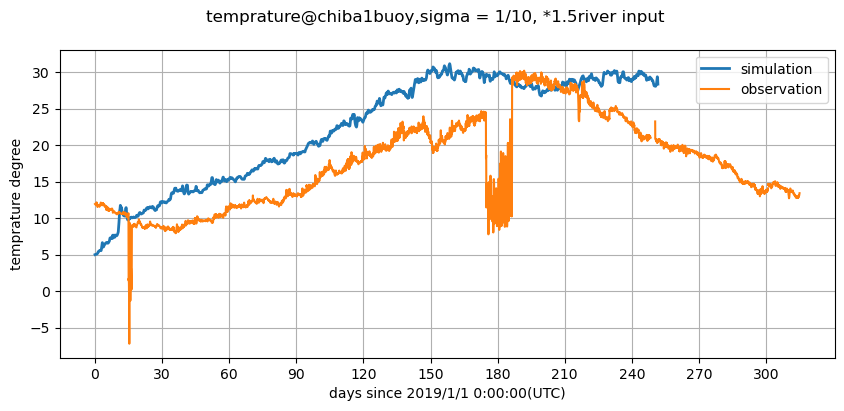

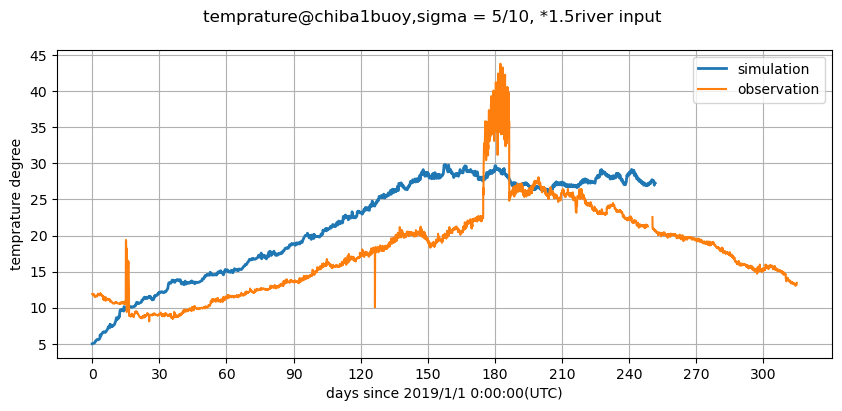

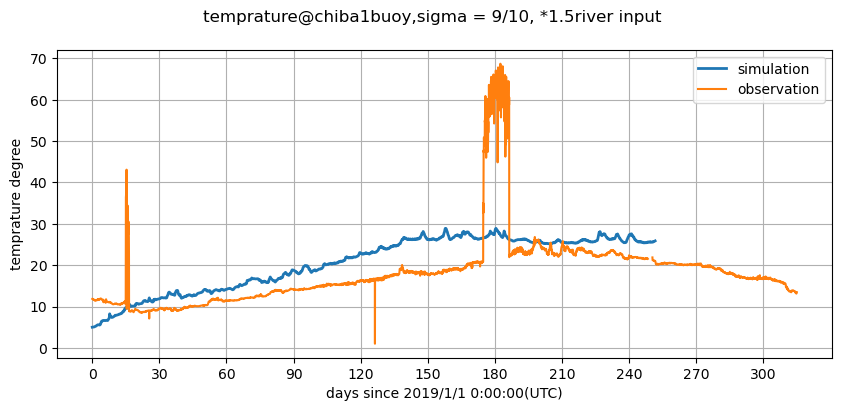

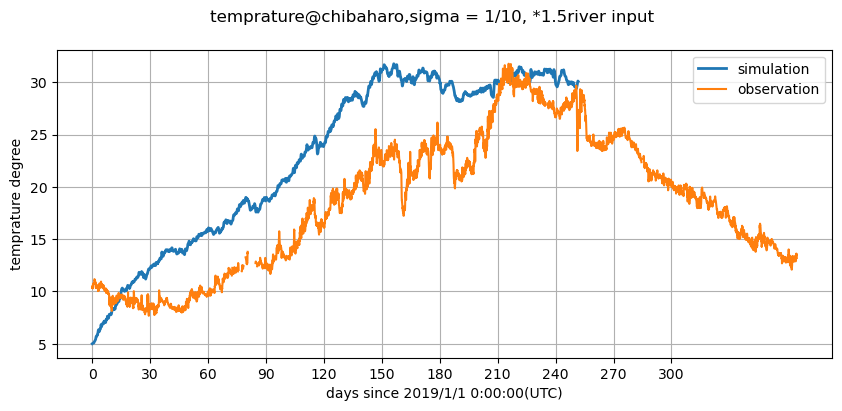

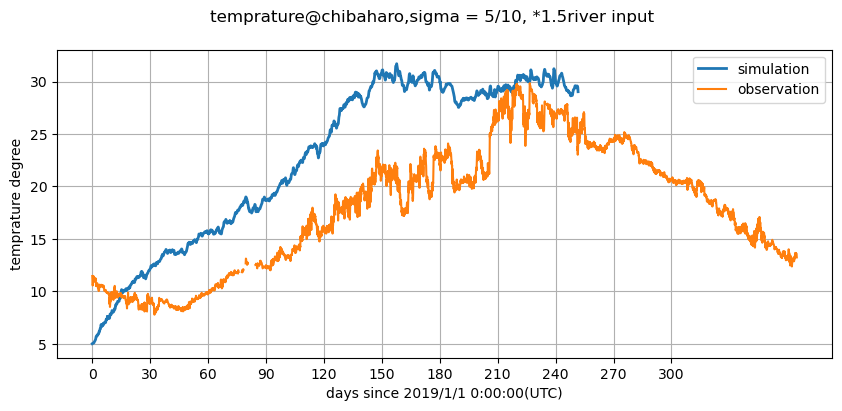

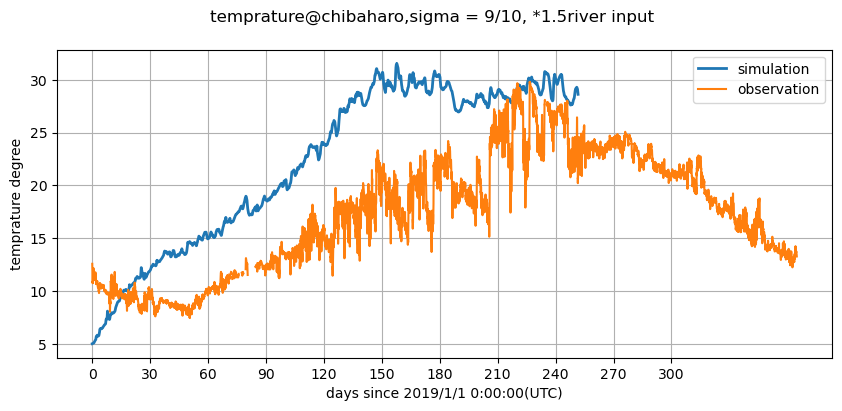

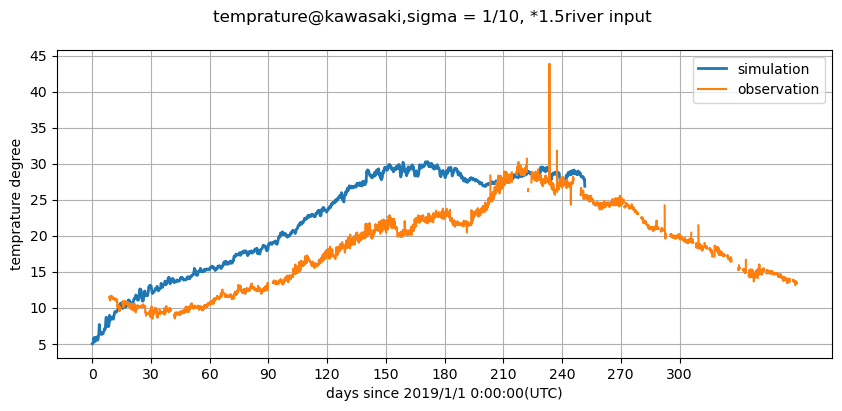

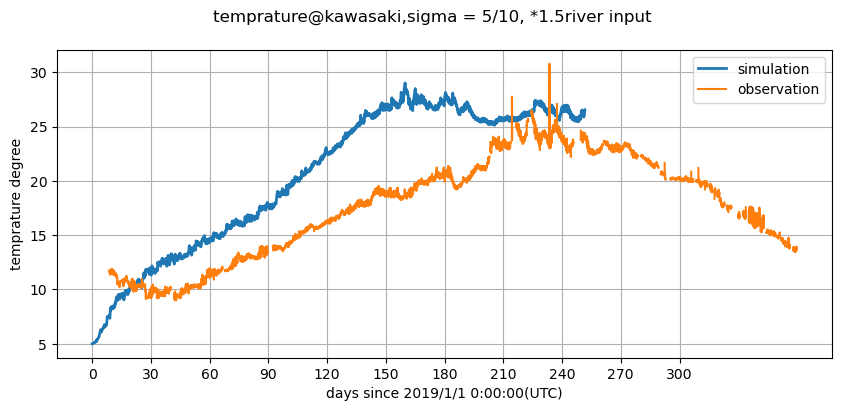

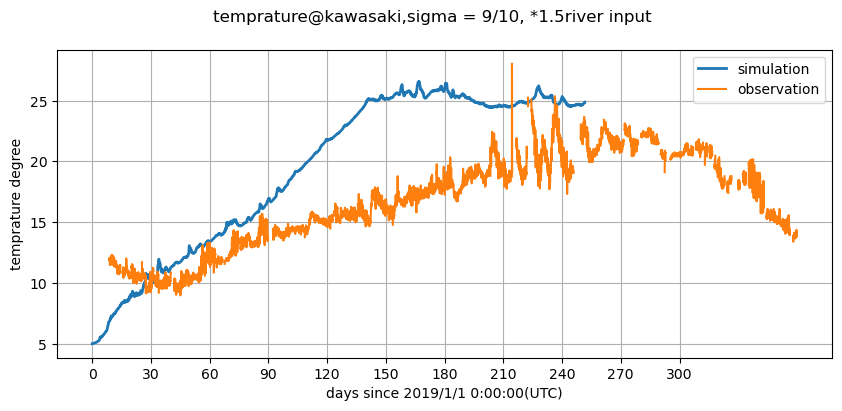

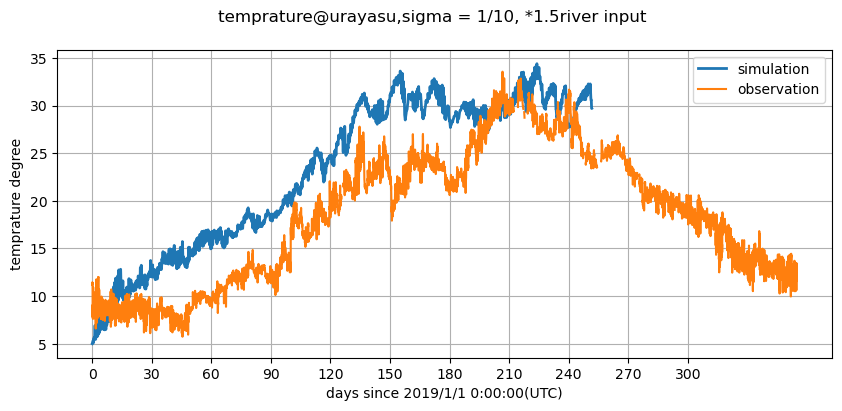

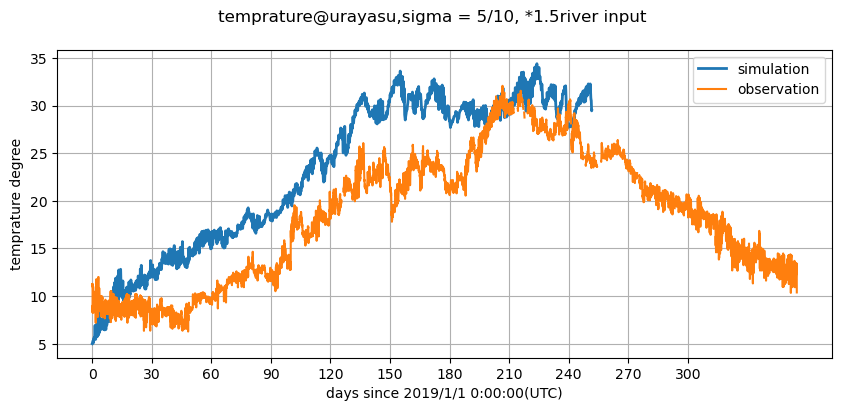

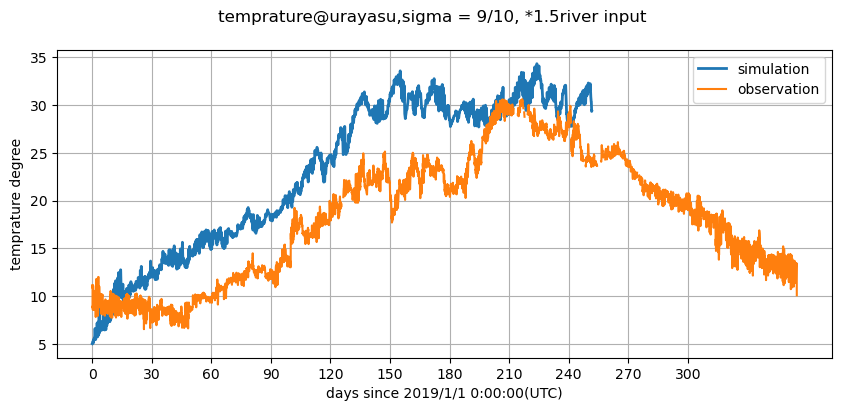

In [83]:
stn_node = find_closest_node(stn)
def plotter(stn_node,var): 
    cc = {}
    rmse = {}
    for key in stn_node:
        index = stn_node[key]
        #read Mpos_S
        f = 'C:/Users/ishid/Github/Puppeteer/src/csv/Mpos_S_' + key +'_2019.csv'
        df = pd.read_csv(f,usecols=['depth','tp','sl','datetime','lev'])
        
        regress = regress_dict_tp[key] #dictのdict形式でまとまっている
        sigma =[1,5,9]
        h = fvcom.z[index] #深さ
        dates = df['datetime'].unique() #get timeseries
        for k in sigma:
            h_sig = h*k/10
            res = np.zeros(len(dates))
            i = 0
            for date in dates:
                res[i] = regress[date][0] * h_sig + regress[date][1] #y =ax+b
                if res[i] == 0:
                    res[i] = np.nan
                #debug
                if abs(res[i])>40 or regress[date][0]>100 or regress[date][1]>100 :
                    print(res[i],i)
                i+=1
            
    #plot
            fig = plt.figure(figsize=(10,4))
            ax = fig.add_subplot(1,1,1,xlabel = 'days since 2019/1/1 0:00:00(UTC)',ylabel='temprature degree')
            ax.plot(temp[:,k, index],linewidth=2,label='simulation') #float64 temp(time, siglay, node)
            ax.plot(res[:],label='observation')
            fig.suptitle('temprature@{},sigma = {}/10, *1.5river input'.format(key,k))
            ax.legend()
            plt.grid()
            plt.xticks([24*30*i for i in range(11)], [30*i for i in range(11)])
            plt.plot()
            fig.savefig('temp_15'+key+'_'+str(k)+'.png')
            print('save figure@sigma={},stn={}'.format(k,key))
            
    #calc RMSE and CC
            #RMSE
            Time_list = fvcom.time_list()
            X = []
            Y = []
            res = 0
            for i in range(len(Time_list)):
                if Time_list[i] in regress.keys():
                    X.append(temp[i,k,index].item())
                    Y.append(regress[Time_list[i]][0] * h_sig + regress[Time_list[i]][1])
                    res += (temp[i,k,index].item()-(regress[Time_list[i]][0] * 0 + regress[Time_list[i]][1]))**2
            Rmse = math.sqrt(res/len(X))
            #CC
            Cc = calc_cc(X,Y)
            cc[key] = Cc
            rmse[key] = Rmse
    return rmse,cc

cc = plotter(stn_node,'temprature')

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh. (c:\users\ishid\github\pyfvcom-main\PyFVCOM\plot.py:443)


NameError: name 'save' is not defined

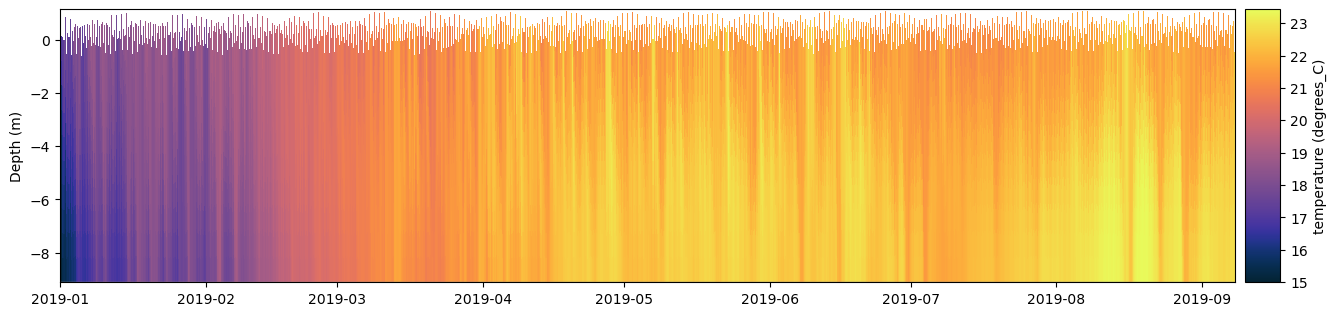

In [88]:
#make contor
import numpy as np
## Load an FVCOM model output and plot surface
from PyFVCOM.read import FileReader
from PyFVCOM.read import ncread
from PyFVCOM.plot import Plotter, Time, Depth
from PyFVCOM.tide import make_water_column
from PyFVCOM.grid import unstructured_grid_depths
from cmocean import cm
import matplotlib.pyplot as plt
from pyproj import Proj
import sys
import warnings
# warnings.simplefilter('ignore') # Comment out to show warnings
%matplotlib inline

#fvcom = FileReader(f, dims={'time': slice(0, 1000)}, variables=['zeta', 'temp', 'u'])
#gauge = (140.05, 35.57)  # a sample (lon, lat) position for Estuary example
#index = fvcom.closest_node(gauge).item()  ### ndarray -> scalar
# print(index) # 295

#fvcom = FileReader('Tokyo2_0001_dt3.nc', variables=['zeta', 'temp'], dims={'time': slice(0,6000), 'node': 150})
time = Time(fvcom, figsize=(40, 9),cmap=cm.thermal, cb_label='{} ({})'.format(fvcom.atts.temp.long_name,
                                                              fvcom.atts.temp.units))
z = unstructured_grid_depths(fvcom.grid.h, fvcom.data.zeta, fvcom.grid.siglay)
## print("z.shape", z.shape)
## fill_seabed makes the part of the plot below the seabed grey.
## We need to squeeze the data array since we've only extracted a single position.
## print(fvcom.grid.h.shape)
## print(fvcom.grid.h)
time.plot_surface(z, fvcom.data.temp, fill_seabed=True, h_offset=0, h_min=fvcom.grid.h)
time.axes.set_ylabel('Depth (m)')
save('test.png')